### Phase 4 (Modeling)

| Target | Description | Data Type | Analysis Type |
| --- | --- | --- | --- |
| Price| The price of the vehicle | int64 | Regression |

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,  root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Load your cleaned dataset

In [2]:
# df = pd.read_csv("../Data/cars_price_prediction.csv")
df = pd.read_csv("../Data/cars_price_prediction.csv")

feature_columns = [
	"engine_type",
	"fuel_type",
	"transmission",
	"body_type",
	"has_incidents",
	"wheel_system",
	"horsepower",
	"maximum_seating",
	"mileage",
	"torque",
	"year",
	"combined_fuel_economy",
	"legroom",
	"major_options_count",
	"size_of_vehicle"
]

In [3]:
set(df.columns) - set(feature_columns)

{'price'}

In [4]:
set(df.columns)-set(feature_columns+['price'])

set()

In [5]:

df.drop(columns=set(df.columns)-set(feature_columns+['price']), inplace=True)

In [6]:
df.sample(5)

,engine_type,fuel_type,transmission,body_type,has_incidents,wheel_system,horsepower,maximum_seating,mileage,torque,year,combined_fuel_economy,legroom,major_options_count,size_of_vehicle,price
344219,6.0,5.0,0,5,0,3,161.0,5,5.0,150.000000,2021,25.5,79.7,6.0,435.7,10.176792
640039,6.0,6.0,1,6,0,3,188.0,5,1041.0,264.273155,2020,42.0,82.6,6.0,459.5,10.233942
1728605,6.0,5.0,0,5,0,2,250.0,5,7.0,280.000000,2020,24.5,83.2,8.0,473.6,10.417359
1273290,6.0,5.0,0,6,0,3,153.0,5,57831.0,264.273155,2016,36.0,78.1,4.0,431.6,9.332115
2558109,6.0,5.0,0,2,0,3,160.0,5,40581.0,146.000000,2018,29.0,76.3,3.0,426.7,9.383285


### Explore data

In [7]:
display(df.info())
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625910 entries, 0 to 2625909
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   engine_type            float64
 1   fuel_type              float64
 2   transmission           int64  
 3   body_type              int64  
 4   has_incidents          int64  
 5   wheel_system           int64  
 6   horsepower             float64
 7   maximum_seating        int64  
 8   mileage                float64
 9   torque                 float64
 10  year                   int64  
 11  combined_fuel_economy  float64
 12  legroom                float64
 13  major_options_count    float64
 14  size_of_vehicle        float64
 15  price                  float64
dtypes: float64(10), int64(6)
memory usage: 320.5 MB


None

,engine_type,fuel_type,transmission,body_type,has_incidents,wheel_system,horsepower,maximum_seating,mileage,torque,year,combined_fuel_economy,legroom,major_options_count,size_of_vehicle,price
count,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06
mean,7.074013e+00,4.878645e+00,2.117491e-01,4.889393e+00,6.587811e-02,2.174839e+00,2.436271e+02,5.438198e+00,2.083565e+04,2.642732e+02,2.018348e+03,2.614862e+01,8.024379e+01,6.325709e+00,4.703230e+02,1.022088e+01
std,2.008846e+00,6.564600e-01,5.129378e-01,1.241023e+00,2.480690e-01,1.220162e+00,9.050989e+01,1.141106e+00,2.850102e+04,1.079547e+02,3.233862e+00,7.641223e+00,3.322577e+00,3.465664e+00,4.873382e+01,5.104482e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e+01,2.000000e+00,0.000000e+00,6.800000e+01,1.915000e+03,9.500000e+00,0.000000e+00,1.000000e+00,3.102000e+02,5.545177e+00
25%,6.000000e+00,5.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,2.000000e+00,1.700000e+02,5.000000e+00,5.000000e+00,1.810000e+02,2.017000e+03,2.250000e+01,7.820000e+01,4.000000e+00,4.402000e+02,9.899580e+00
50%,6.000000e+00,5.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,3.000000e+00,2.280000e+02,5.000000e+00,1.099000e+03,2.642732e+02,2.020000e+03,2.500000e+01,8.016630e+01,6.000000e+00,4.565000e+02,1.022176e+01
75%,9.000000e+00,5.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,3.000000e+00,3.000000e+02,6.000000e+00,3.524600e+04,2.750000e+02,2.020000e+03,2.850000e+01,8.170000e+01,8.000000e+00,4.854000e+02,1.057252e+01
max,1.000000e+01,7.000000e+00,3.000000e+00,8.000000e+00,1.000000e+00,4.000000e+00,1.001000e+03,1.500000e+01,1.091460e+05,9.440000e+02,2.021000e+03,1.270000e+02,1.049636e+02,5.900000e+01,7.020000e+02,1.500943e+01


engine_type              0
fuel_type                0
transmission             0
body_type                0
has_incidents            0
wheel_system             0
horsepower               0
maximum_seating          0
mileage                  0
torque                   0
year                     0
combined_fuel_economy    0
legroom                  0
major_options_count      0
size_of_vehicle          0
price                    0
dtype: int64

### Feature Selection

In [8]:
X = df.drop(['price'], axis=1)  # drop target column from features
y = df['price']

### Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale your features

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
len(X_train.columns), X_train.columns

(15,
 Index(['engine_type', 'fuel_type', 'transmission', 'body_type',
        'has_incidents', 'wheel_system', 'horsepower', 'maximum_seating',
        'mileage', 'torque', 'year', 'combined_fuel_economy', 'legroom',
        'major_options_count', 'size_of_vehicle'],
       dtype='object'))

### Train Models

**LinearRegression**

In [12]:
# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


LinearRegression()

**XGBRegressor**

In [13]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# Predict LinearRegression
lr_pred = lr_model.predict(X_test_scaled)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)

# Print results
print("Evaluation Metrics for Price Prediction (Linear Regression)")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
print(f"R² Score   : {r2:.4f}")


Evaluation Metrics for Price Prediction (Linear Regression)
RMSE       : 0.2575
MAE        : 0.1882
R² Score   : 0.7462


In [15]:
#Predict XGBoost
xgb_pred = xgb_model.predict(X_test)

rmse = root_mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print("Evaluation Metrics for Price Prediction (XGBoost)")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
print(f"R² Score   : {r2:.4f}")


Evaluation Metrics for Price Prediction (XGBoost)
RMSE       : 0.1433
MAE        : 0.1036
R² Score   : 0.9214


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


assert X_train_scaled.shape[0] == y_train.shape[0], "check size X_train and y_train gap!"
assert X_test_scaled.shape[0] == y_test.shape[0], "check size X_test and y_test gap!"

mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mlp.fit(X_train_scaled, y_train, validation_split=0.2, epochs=40, batch_size=2048, callbacks=[early_stopping], verbose=1)

# Predict
mlp_pred = mlp.predict(X_test_scaled)
if mlp_pred.ndim > 1:
    mlp_pred = mlp_pred.flatten()

# Evaluation
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, mlp_pred)))
print("MLP MAE:", mean_absolute_error(y_test, mlp_pred))
print("MLP R²:", r2_score(y_test, mlp_pred))


Epoch 1/40


c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.2919 - mae: 3.3293 - val_loss: 0.4088 - val_mae: 0.4895
Epoch 2/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0558 - mae: 1.1411 - val_loss: 0.1157 - val_mae: 0.2609
Epoch 3/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5739 - mae: 0.9995 - val_loss: 0.0802 - val_mae: 0.2179
Epoch 4/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2972 - mae: 0.9060 - val_loss: 0.0667 - val_mae: 0.1935
Epoch 5/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0793 - mae: 0.8253 - val_loss: 0.0741 - val_mae: 0.2069
Epoch 6/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9626 - mae: 0.7802 - val_loss: 0.0609 - val_mae: 0.1852
Epoch 7/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8778 - mae: 0.7444 - val_loss: 0.0475 - val_mae: 0.1600
Epoch 8/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7858 - mae: 0.7044 - val_loss: 0.0519 - val_mae: 0.1690
Epoch 9/40
821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6892

In [17]:
# Gather evaluation results
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = r2_score(y_test, mlp_pred)

# Create DataFrame
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Linear Regression","XGBoost", "MLP (Neural Network)"],
    "RMSE": [lr_rmse, xgb_rmse, mlp_rmse],
    "MAE": [lr_mae, xgb_mae, mlp_mae],
    "R² Score": [lr_r2, xgb_r2, mlp_r2]
})

print(comparison_df)


                  Model      RMSE       MAE  R² Score
0     Linear Regression  0.257470  0.188230  0.746222
1               XGBoost  0.143330  0.103593  0.921354
2  MLP (Neural Network)  0.174266  0.126699  0.883741


#### Visualize Performance

##### a. Actual vs Predicted Plot

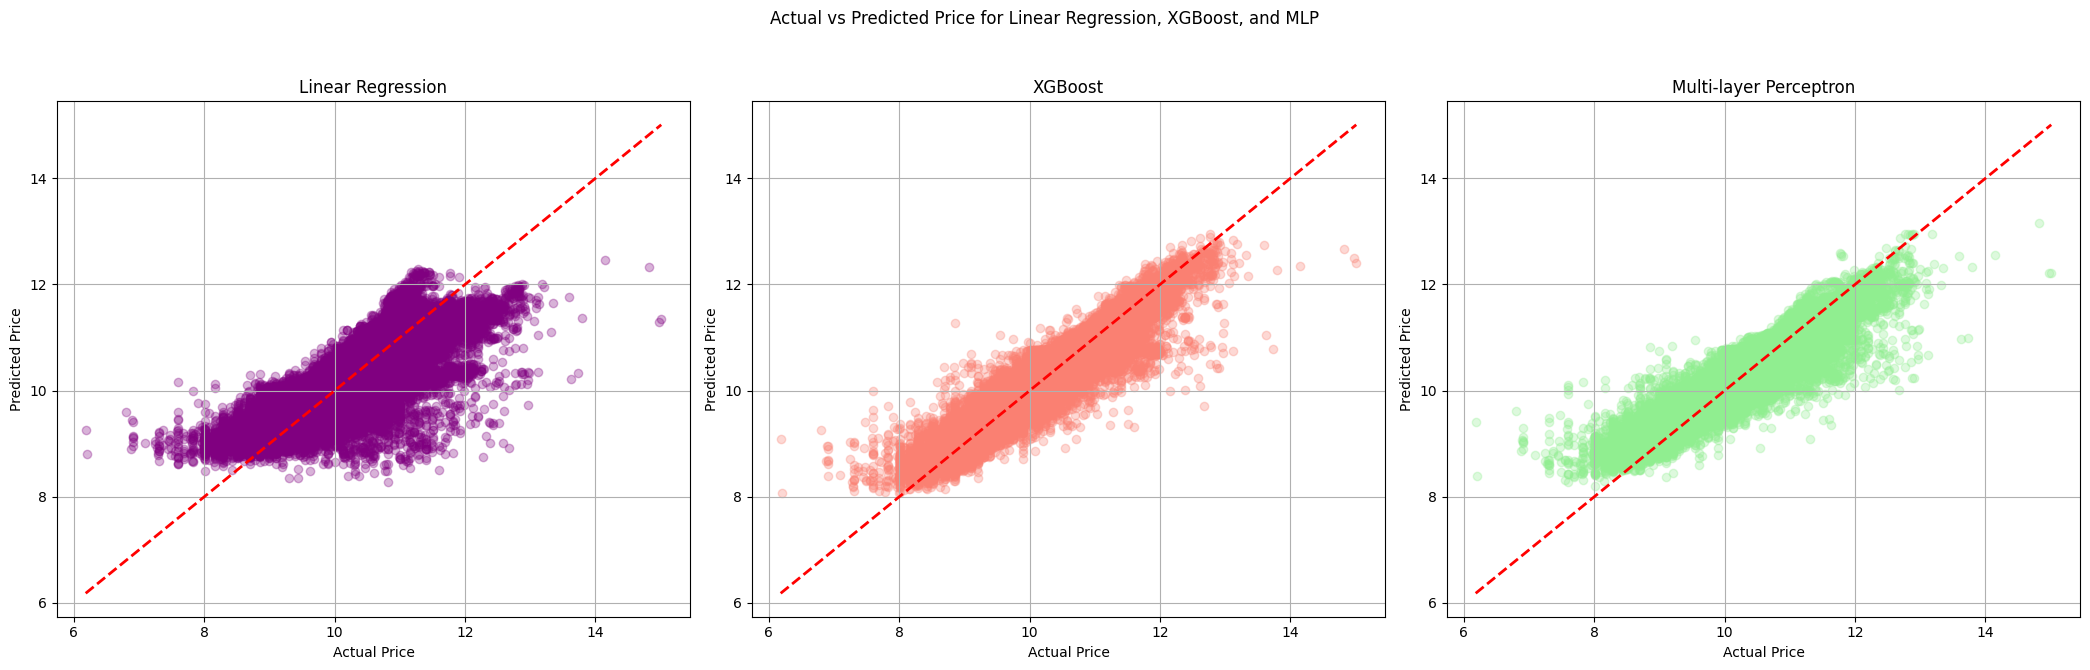

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Actual vs Predicted Price for Linear Regression, XGBoost, and MLP')

# Actual vs Predicted Linear Regression
axes[0].scatter(y_test, lr_pred, alpha=0.3, color='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Linear Regression')
axes[0].grid(True)

# Actual vs Predicted XGBoost
axes[1].scatter(y_test, xgb_pred, alpha=0.3, color='salmon')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('XGBoost')
axes[1].grid(True)

axes[2].scatter(y_test, mlp_pred, alpha=0.3, color='lightgreen')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Price')
axes[2].set_ylabel('Predicted Price')
axes[2].set_title('Multi-layer Perceptron')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### b. Residual Plot

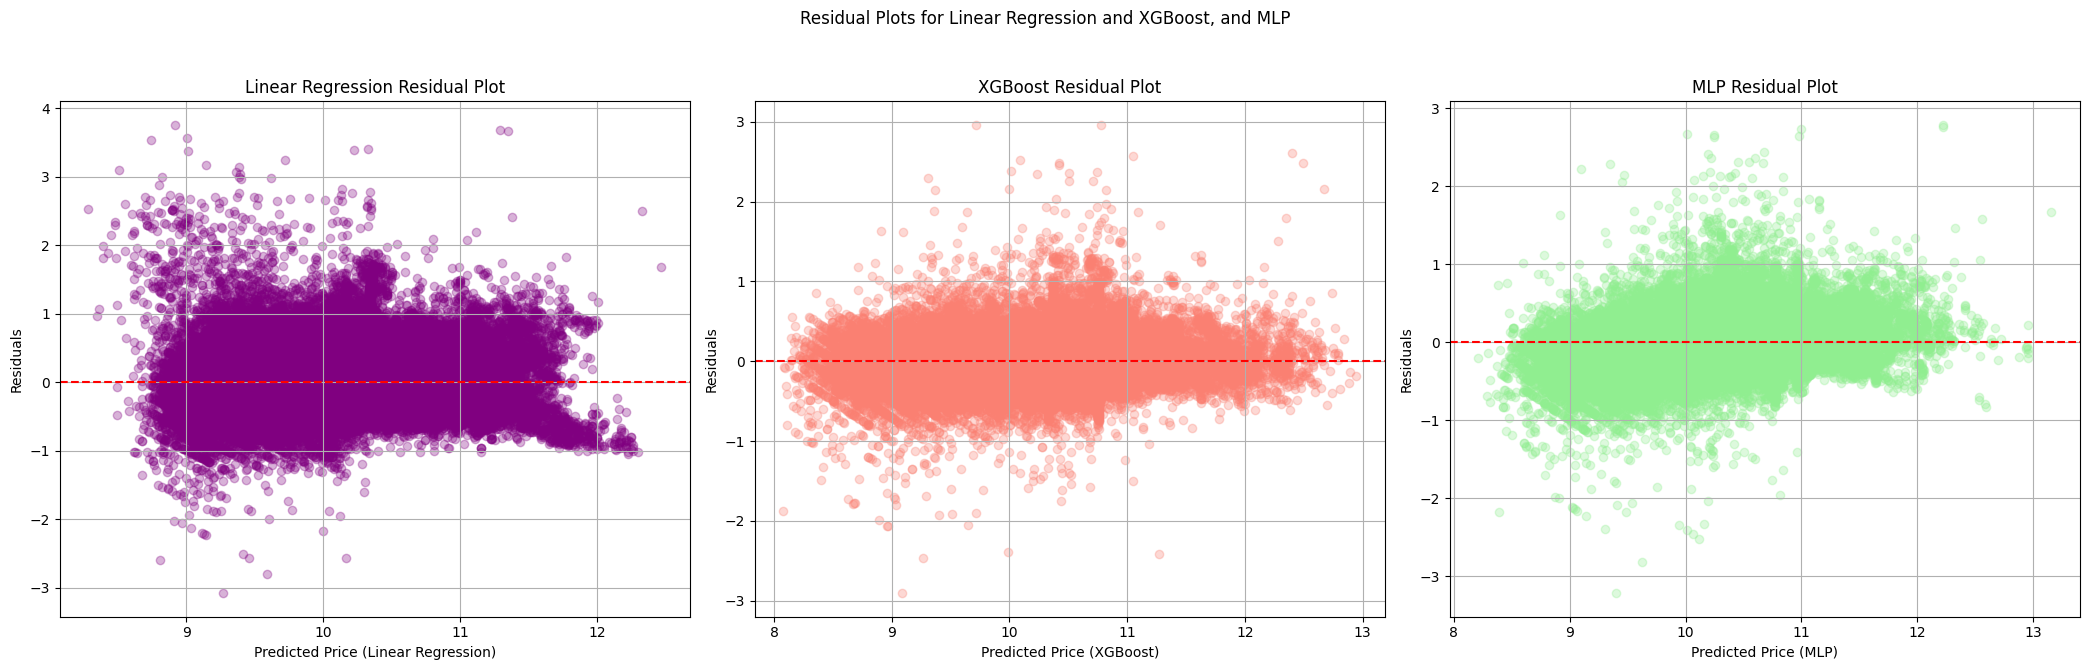

In [19]:
residuals_lr = y_test - lr_pred
residuals_xgb = y_test - xgb_pred
residuals_mlp = y_test - mlp_pred

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Residual Plots for Linear Regression and XGBoost, and MLP')

# residual Linear Regression
axes[0].scatter(lr_pred, residuals_lr, alpha=0.3, color='purple')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Price (Linear Regression)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression Residual Plot')
axes[0].grid(True)

# residual  XGBoost
axes[1].scatter(xgb_pred, residuals_xgb, alpha=0.3, color='salmon')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Price (XGBoost)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('XGBoost Residual Plot')
axes[1].grid(True)

axes[2].scatter(mlp_pred, residuals_mlp, alpha=0.3, color='lightgreen')
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel('Predicted Price (MLP)')
axes[2].set_ylabel('Residuals')
axes[2].set_title('MLP Residual Plot')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

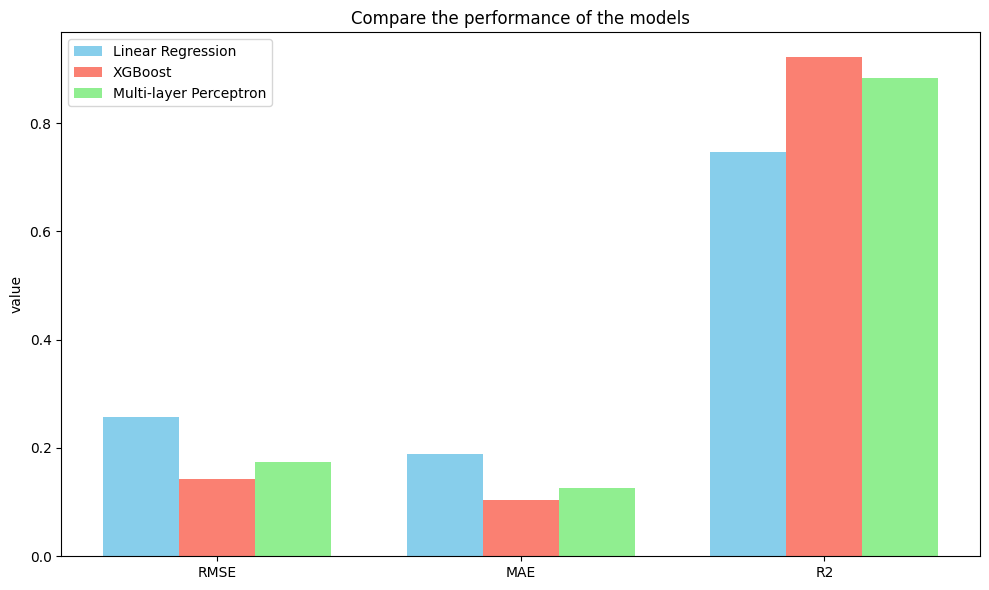

In [20]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Linear Regression', 'XGBoost', 'Multi-layer Perceptron']

metrics = ['RMSE', 'MAE', 'R2']

values = {
    'Linear Regression': [lr_rmse, lr_mae, lr_r2],
    'XGBoost': [xgb_rmse, xgb_mae, xgb_r2],
    'Multi-layer Perceptron': [mlp_rmse, mlp_mae, mlp_r2]
}

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, values['Linear Regression'], width, label='Linear Regression', color='skyblue')
rects2 = ax.bar(x, values['XGBoost'], width, label='XGBoost', color='salmon')
rects3 = ax.bar(x + width, values['Multi-layer Perceptron'], width, label='Multi-layer Perceptron', color='lightgreen')

ax.set_ylabel('value')
ax.set_title('Compare the performance of the models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

##### Hyperparameter Tuning for MLP (Keras)

In [21]:
models = []
results = []

param_sets = [
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1,  "subsample": 0.8, "colsample_bytree": 0.8 },
    {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.01, "subsample": 0.7, "colsample_bytree": 0.9 },
    {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05,  "subsample": 0.9, "colsample_bytree": 0.7 }
]

for i, params in enumerate(param_sets):
    model = xgb.XGBRegressor(
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    models.append(model)
    results.append({
        'Model': f'model_{i+1}',
        'Params': params,
        'RMSE': root_mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })


results_df = pd.DataFrame(results)
results_df

,Model,Params,RMSE,MAE,R2
0,model_1,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.143856,0.104232,0.920775
1,model_2,"{'n_estimators': 150, 'max_depth': 6, 'learnin...",0.224681,0.167144,0.806743
2,model_3,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.143627,0.103900,0.921027


- model_1 & model_3 are almost equivalent, both have R2 = 0.92 → The configuration is working stably and well.
- model_2 has learning_rate = 0.01 but the number of trees is not large enough (only 150), leading to underfitting => poor results.

Solution test:  
Smaller learning_rate is better when n_estimators is higher   
- Try n_estimators  300–500 with learning_rate=0.01  
- Try max_depth=5 and max_depth=7 to control overfitting  
- Try again colsample_bytree = 0.75 or 0.85 to control noise  

In [22]:
models = []
results = []

param_sets = [
    {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01,  "subsample": 0.8, "colsample_bytree": 0.8 },
    {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.03,  "subsample": 0.9, "colsample_bytree": 0.75 },
    {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05,  "subsample": 0.8, "colsample_bytree": 0.85 }
]


for i, params in enumerate(param_sets):
    model = xgb.XGBRegressor(
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    models.append(model)
    results.append({
        'Model': f'model_{i+1}',
        'Params': params,
        'RMSE': root_mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })


results_df = pd.DataFrame(results)
results_df

,Model,Params,RMSE,MAE,R2
0,model_1,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",0.175128,0.128419,0.882588
1,model_2,"{'n_estimators': 250, 'max_depth': 6, 'learnin...",0.149311,0.108552,0.914653
2,model_3,"{'n_estimators': 200, 'max_depth': 7, 'learnin...",0.134438,0.096691,0.930809


Highest R2 (0.93) => explains **93%** of data variance  
Compared to previous times, this model improves significantly thanks to **max_depth=7** and **learning_rate=0.05.**   

In [23]:
models = []
results = []

param_sets = [
    {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.05,  "subsample": 0.8, "colsample_bytree": 0.8 }
]

for i, params in enumerate(param_sets):
    model = xgb.XGBRegressor(
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    models.append(model)
    results.append({
        'Model': f'model_{i+1}',
        'Params': params,
        'RMSE': root_mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df

,Model,Params,RMSE,MAE,R2
0,model_1,"{'n_estimators': 400, 'max_depth': 8, 'learnin...",0.12119,0.085985,0.943774


**RESULT** : RMSE decreased by ~15%, MAE decreased by ~17%, and R2 increased from **0.92 → 0.94** => the model predicted significantly more accurately.  
- Increasing **n_estimators** to 400 helps the model learn deeper (with a small **learning_rate**).  
- Reducing **learning_rate** helps the weight update smoother, avoiding early overfitting.  
- Increasing **max_depth** to 8 helps the model exploit more complex information in the data.  

In [24]:
xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

#Predict XGBoost
xgb_pred = xgb_model.predict(X_test)

rmse = root_mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print("Evaluation Metrics for Price Prediction (XGBoost)")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
print(f"R² Score   : {r2:.4f}")


Evaluation Metrics for Price Prediction (XGBoost)
RMSE       : 0.1213
MAE        : 0.0861
R² Score   : 0.9437


**The result reflects the best model we have is XGBoost and now we export this model to proceed to the next step.**

In [25]:
xgb_model.save_model('../Data/xgb_price_prediction.model')
mlp.save('../Data/mlp_price_prediction.keras')
joblib.dump(lr_model, '../Data/lr_price_prediction.pkl')
joblib.dump(scaler, "../Data/scaler_price_prediction.pkl")

c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [14:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


['../Data/scaler_price_prediction.pkl']

### Testing

In [26]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb


sample_data = {
    "engine_type": 1,
    "fuel_type": 0,
    "transmission": 1,
    "body_type": 2,
    "has_incidents": 0,
    "wheel_system": 1,
    "horsepower": 150.0,
    "maximum_seating": 5,
    "mileage": 60000.0,
    "torque": 200.0,
    "year": 2018,
    "combined_fuel_economy": 20,
    "legroom": 40.0,
    "major_options_count": 5.0,
    "size_of_vehicle": 3.0
}
input_list = [
    sample_data["engine_type"],
    sample_data["fuel_type"],
    sample_data["transmission"],
    sample_data["body_type"],
    sample_data["has_incidents"],
    sample_data["wheel_system"],
    sample_data["horsepower"],
    sample_data["maximum_seating"],
    sample_data["mileage"],
    sample_data["torque"],
    sample_data["year"],
    sample_data["combined_fuel_economy"],
    sample_data["legroom"],
    sample_data["major_options_count"],
    sample_data["size_of_vehicle"]
]
# horsepower               0
# maximum_seating          0
# mileage                  0
# torque                   0
# year                     0
# combined_fuel_economy    0
# legroom                  0
# major_options_count      0
# size_of_vehicle          0
feature_names = [
    "engine_type", "fuel_type", "transmission", "body_type", "has_incidents", "wheel_system",
    "horsepower", "maximum_seating", "mileage", "torque", "year",
    "combined_fuel_economy", "legroom", "major_options_count", "size_of_vehicle"
]

# convert numpy array 2D
input_array = np.array([input_list])

In [27]:
# Load
lr_model = joblib.load("../Data/lr_price_prediction.pkl")
scaler = joblib.load("../Data/scaler_price_prediction.pkl")


# Scale
scaled_input = scaler.transform(input_array)

# Predict
lr_pred = lr_model.predict(scaled_input)


c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [28]:
# Load model 
xgb_model = xgb.Booster()
xgb_model.load_model('../Data/xgb_price_prediction.model')

input_df = pd.DataFrame([input_list], columns=feature_names)

# Convert to DMatrix
dtest = xgb.DMatrix(input_df)

# Predict
xgb_pred = xgb_model.predict(dtest)



In [29]:
mlp_model = load_model('../Data/mlp_price_prediction.keras')
scaler = joblib.load('../Data/scaler_price_prediction.pkl')

# Scale
scaled_input = scaler.transform(input_array)

# Predict
mlp_pred = mlp_model.predict(scaled_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [30]:
print(f"- XGBoost prediction:                   {xgb_pred}")
print(f"- Multi-layer Perceptron prediction:    {mlp_pred}")
print(f"- Linear Regression prediction:         {lr_pred}")


- XGBoost prediction:                   [9.75039]
- Multi-layer Perceptron prediction:    [[9.819779]]
- Linear Regression prediction:         [10.1759749]
